In [1]:
import pandas as pd
# uses positioning information from GeoNames (https://www.geonames.org) to find landfall country/state from coordinates
# GeoNames database from https://download.geonames.org/export/dump/
# need US, Mexico, and Canada to differentiate landfalls that are close
geonames_dbs_txt = ['US/US.txt', 'MX/MX.txt', 'CA/CA.txt']
# this will be created in the cell below
geonames_db_sqlite = 'USMXCA.sqlite'

# best track data from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_na_csv = 'ibtracs.NA.list.v04r00.csv'
best_tracks_ep_csv = 'ibtracs.EP.list.v04r00.csv'

In [2]:
# create the geonames db (only do once!)
import sqlite3
import os

## ONLY RUN THIS CELL ONCE
if not os.path.isfile(geonames_db_sqlite):
    # Create a new SQLite database or connect to an existing one
    conn = sqlite3.connect(geonames_db_sqlite)
    cursor = conn.cursor()

    # Create a table to store the Geonames data
    cursor.execute('''
        CREATE TABLE geonames (
            geonameid INTEGER PRIMARY KEY,
            name TEXT,
            latitude REAL,
            longitude REAL,
            country TEXT,
            state TEXT
        )
    ''')

    for geonames_db_txt in geonames_dbs_txt:
        # Read and import data from the "US.txt" file into the database
        with open(geonames_db_txt, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 10:
                    geonameid, name, latitude, longitude, country, state = (
                        int(parts[0]), parts[1], float(parts[4]), float(parts[5]), parts[8], parts[10]
                    )
                    cursor.execute('''
                        INSERT INTO geonames (geonameid, name, latitude, longitude, country, state)
                        VALUES (?, ?, ?, ?, ?, ?)
                    ''', (geonameid, name, latitude, longitude, country, state))

    # Commit changes and close the database connection
    conn.commit()
    conn.close()


In [80]:
import sqlite3
import math
import matplotlib.pyplot as plt

# Constants for Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# for calculating probabilities
default_start_year = 1851
default_end_year = 2002

# Function to calculate the Haversine distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c

    return distance


def find_nearest_country_and_state(conn, lat, lon):
    cursor = conn.cursor()
    
    # Query the database to find the nearest place based on coordinates
    cursor.execute("""
        SELECT country, state, latitude, longitude FROM geonames
        WHERE latitude BETWEEN ? AND ?
        AND longitude BETWEEN ? AND ?
        ORDER BY ((latitude - ?) * (latitude - ?) + (longitude - ?) * (longitude - ?))
        LIMIT 1
    """, (lat - 1, lat + 1, lon - 1, lon + 1, lat, lat, lon, lon))

    result = cursor.fetchone()
    cursor.close()

    if result:
        country, state, place_lat, place_lon = result
        if str(state) != '00':
            distance = haversine_distance(lat, lon, place_lat, place_lon)
            return country, state, distance

    return None, None, None

# create a new empty dataframe with same template
def copy_df_structure(df_reference):
    new_df = df_reference.copy(deep=False)
    new_df.astype(df_reference.dtypes.to_dict())
    new_df = new_df[0:0]
    return new_df

# add landfall state for all US tropical storms and subtropical storms
def get_us_landfalls(df_reference):
    df_new_landfalls = copy_df_structure(df_reference)
    df_new_landfalls.reset_index()
    US_state_abbrevs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    # Connect to the SQLite database containing Geonames data
    conn = sqlite3.connect(geonames_db_sqlite)
    us_state_landfalls = []
    for i in range(len(df_reference)):
        entry = df_reference.iloc[i]
        latitude = float(entry['USA_LAT'])
        longitude = float(entry['USA_LON'])

        country, state, distance_km = find_nearest_country_and_state(conn, latitude, longitude)
        # it may return state='00' if Mexico is not in sqlite database so double check state is in abbrevs
        if country == 'US' and state in US_state_abbrevs:
            df_new_landfalls.loc[len(df_new_landfalls)] = entry
            df_new_landfalls.reset_index()
            us_state_landfalls.append(state)

    # Don't forget to close the database connection when you're done
    conn.close()

    df_new_landfalls.reset_index()
    df_new_landfalls_with_state = df_new_landfalls.copy(deep=True)
    df_new_landfalls_with_state = df_new_landfalls_with_state.assign(LANDFALL_STATE=us_state_landfalls)
    return df_new_landfalls_with_state

# get the df with us landfall states (or the unique storms when no state supplied), selected by:
#     start/end year,
#     a list of US states where landfall occured (must be a list)
#     from a range within each year (start/end month and day; both must be supplied)
def get_landfalling_conditional(df_reference, states=None,
                                start_year=default_start_year, end_year=default_end_year,
                                start_month_num=None, start_day_num_of_month=None,
                                end_month_num=None, end_day_num_of_month=None):
    # might have multiple landfalls with the same storm, so only count each storm once
    df_new = df_reference.copy(deep=True)
    year_range = list(range(start_year, end_year + 1, 1))
    if states is not None:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range)) & (df_new['LANDFALL_STATE'].isin(states))]
    else:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range))]
    df_new.reset_index()
    # get the mataching year and state first, then drop storm duplicates
    df_new = df_new.drop_duplicates(subset=['USA_ATCF_ID'])
    df_new.reset_index()
    if start_month_num and end_month_num and start_day_num_of_month and end_day_num_of_month:
        # Only include those within the month-day range (inclusive)
        df_new['month'] = df_new['ISO_TIME'].dt.month
        df_new['day'] = df_new['ISO_TIME'].dt.day
        df_new['month_day_sum'] = (df_new['month'] * 100) + df_new['day']
        start_month_day_sum = (start_month_num * 100) + start_day_num_of_month
        end_month_day_sum = (end_month_num * 100) + end_day_num_of_month
        df_new = df_new.loc[
            (df_new['month_day_sum'] >= start_month_day_sum) &
            (df_new['month_day_sum'] <= end_month_day_sum)
        ]
        df_new.reset_index()

    return df_new

# calculate expected probability for exactly expected_num_events this year, given:
#   that a total of num_events have happened over num_years
def poisson_pmf(num_years, num_events, expected_num_events):
    p = num_events / num_years
    xfact = math.factorial(expected_num_events)
    ep = math.pow(p, expected_num_events) / (math.exp(p) * xfact)
    return ep

In [4]:
# Read the CSV file into a DataFrame without automatically assigning column names
df_na = pd.read_csv(best_tracks_na_csv, header=0, skiprows=[1], low_memory=False)
df_ep = pd.read_csv(best_tracks_ep_csv, header=0, skiprows=[1], low_memory=False)
# store all related basin dataframes in one list, with the main one (read from file) separately
dfs_by_basin = {'NA': {'main': df_na}, 'EP': {'main': df_ep}}

In [5]:
# do for both basins (north atlantic and east pacific)
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main']
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_landfalls = df.loc[(df['USA_RECORD'] == 'L')]
    df_ts_ss_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['HU', 'HR']))]
    df_landfalls.reset_index()
    df_ts_ss_landfalls.reset_index()
    df_hu_landfalls.reset_index()
    
    # this will take a while as geonames is slow
    df_us_ts_ss_landfalls_with_state = get_us_landfalls(df_ts_ss_landfalls)
    df_us_hu_landfalls_with_state = get_us_landfalls(df_hu_landfalls)
    
    # for the above landfalls there are duplicates for a single state with different timestamps
    df_us_ts_ss_landfalls_with_state_no_dupe_times = df_us_ts_ss_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_hu_landfalls_with_state_no_dupe_times = df_us_hu_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    
    dict_dfs['us_landfalls_ts_ss'] = df_us_ts_ss_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_hu'] = df_us_hu_landfalls_with_state_no_dupe_times
    dfs_by_basin[basin_name] = dict_dfs

# US Tropical/Subtropical Storm landfalls in records from North Atlantic basin: 273
# US Tropical/Subtropical Storm landfalls from North Atlantic basin, 1980 to 2022 from 10-9 to 11-30 in all US states: 8
[83.02349785034865, 15.4462321582044, 1.4368588054143627, 0.08910752281639459, 0.004144535944948586, 0.00015421529097483112, 4.781869487591662e-06, 1.2709287674662226e-07, 2.955648296433075e-09, 6.109867279448217e-11]


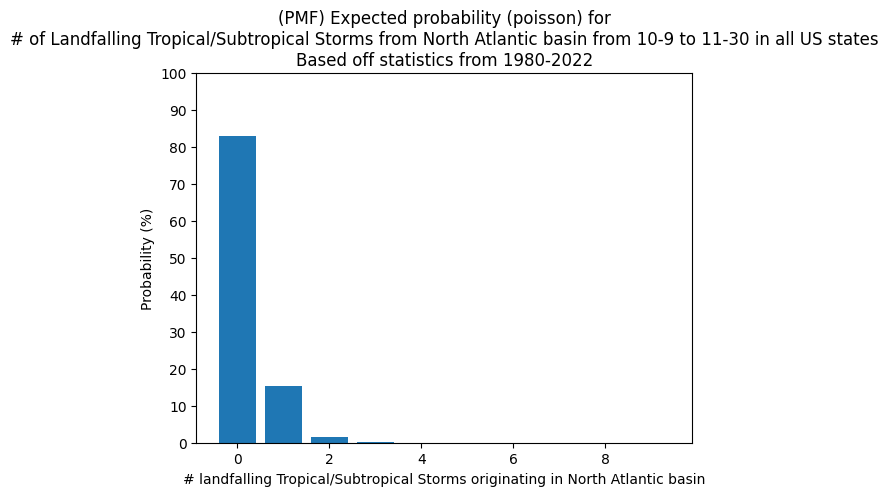

# US Hurricane landfalls in records from North Atlantic basin: 272
# US Hurricane landfalls from North Atlantic basin, 1980 to 2022 from 10-9 to 11-30 in all US states: 10
[79.25036722124435, 18.430317958428915, 2.1430602277242925, 0.16612869982358858, 0.00965864533858073, 0.0004492393180735224, 1.741237666951637e-05, 5.784842747347631e-07, 1.681640333531288e-08, 4.345323859253974e-10]


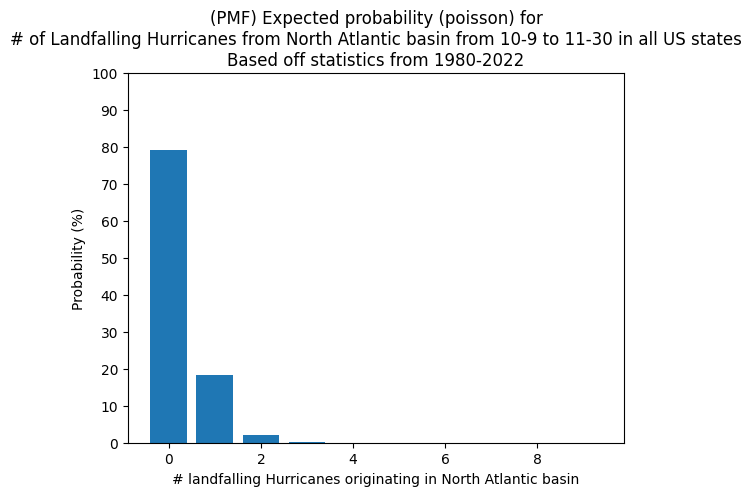

# US Tropical/Subtropical Storm landfalls in records from East Pacific basin: 2
# US Tropical/Subtropical Storm landfalls from East Pacific basin, 1980 to 2022 from 10-9 to 11-30 in all US states: 0
[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


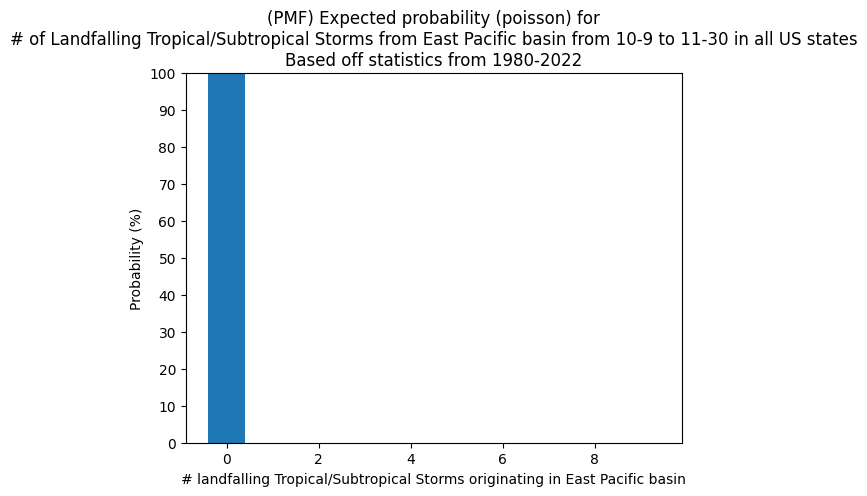

# US Hurricane landfalls in records from East Pacific basin: 4
# US Hurricane landfalls from East Pacific basin, 1980 to 2022 from 10-9 to 11-30 in all US states: 0
[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


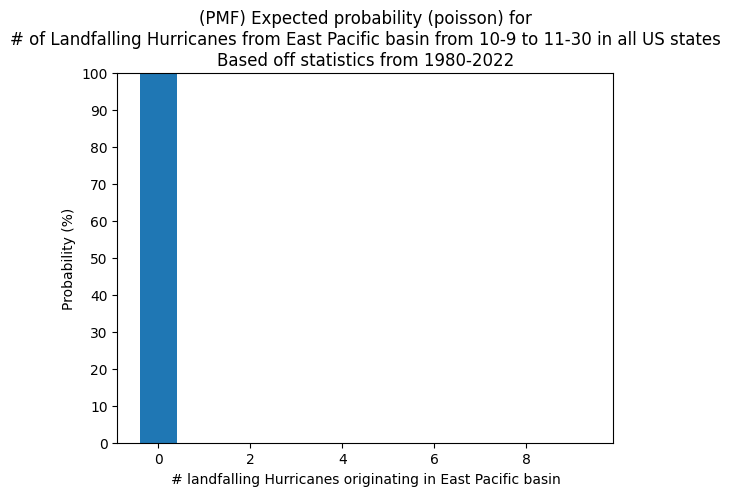

In [218]:
##### BY BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1980
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 9
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['TX']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]    
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]]
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basin:", len(df_unique_storms))
        
        landfalling_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(landfalling_in_period)
        print(f"# US {storm_type_long} landfalls from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

        event_counts = list(range(0,10))
        ep_pct_per_event_count = []
        for n in event_counts:
            ep_pct_per_event_count.append(100 * poisson_pmf(num_years, num_in_period, n))

        print(ep_pct_per_event_count)
        # Create a bar chart
        plt.bar(event_counts, ep_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        # Show the chart
        plt.show()

In [130]:
# join together NA/EP basins dfs
na_and_ep_dfs_by_type = {}
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    if 'main' in na_and_ep_dfs_by_type:
        na_and_ep_dfs_by_type['main'] = pd.concat([na_and_ep_dfs_by_type['main'], dict_dfs['main']])
    else:
        na_and_ep_dfs_by_type['main'] = dict_dfs['main'].copy(deep=True)
    for storm_type_short, storm_type_long in storm_types.items():
        k = storm_type_short_to_dict_key_mapping[storm_type_short]
        df_ref_with_state = dict_dfs[k]
        if k in na_and_ep_dfs_by_type:
            na_and_ep_dfs_by_type[k] = pd.concat([na_and_ep_dfs_by_type[k], df_ref_with_state])
        else:
            na_and_ep_dfs_by_type[k] = df_ref_with_state.copy(deep=True)

# US Tropical/Subtropical Storm landfalls in records from North Atlantic and East Pacific basins: 274
# US Tropical/Subtropical Storm landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-12 to 10-30 in all US states: 0
[100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


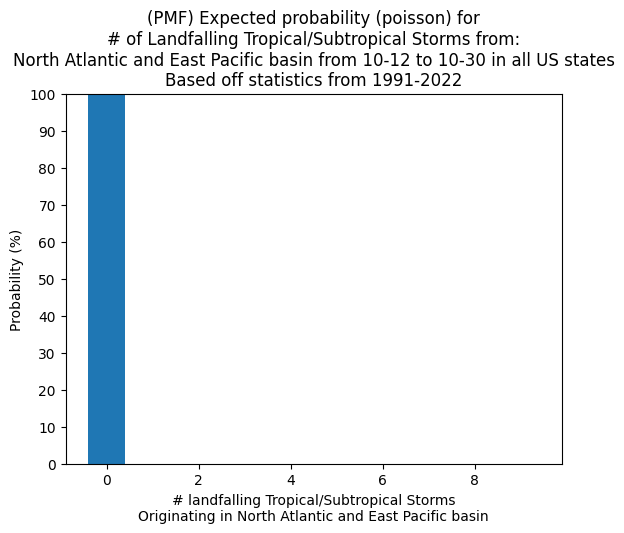

# US Hurricane landfalls in records from North Atlantic and East Pacific basins: 273
# US Hurricane landfalls from North Atlantic and East Pacific basins, 1991 to 2022 from 10-12 to 10-30 in all US states: 3
[91.05103613800341, 8.53603463793782, 0.40012662365333534, 0.01250395698916673, 0.0002930614919335952, 5.494902973754911e-06, 8.585785896492048e-08, 1.1498820397087565e-09, 1.347518015283699e-11, 1.403664599253853e-13]


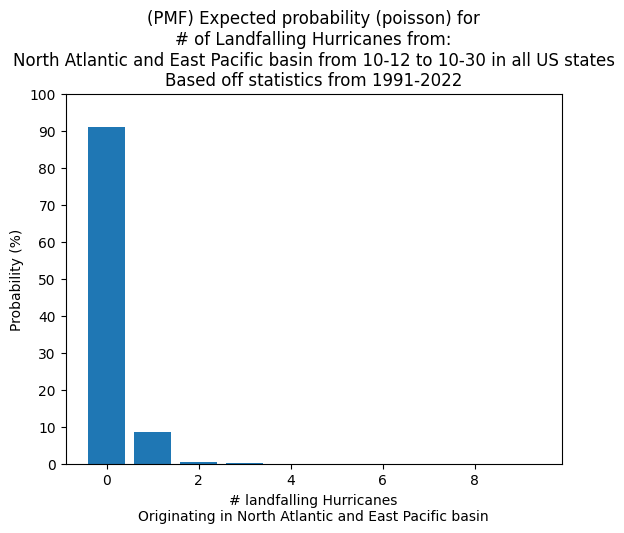

In [214]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 12
end_month = 10
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['TX']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'} 
for storm_type_short, storm_type_long in storm_types.items():
    k = storm_type_short_to_dict_key_mapping[storm_type_short]
    df_ref_with_state = na_and_ep_dfs_by_type[k]
    # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
    df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
    df_unique_storms.reset_index()
    print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basins:", len(df_unique_storms))

    landfalling_in_period = get_landfalling_conditional(
        df_ref_with_state,
        states=states,
        start_year=start_year, end_year=end_year,
        start_month_num=start_month, start_day_num_of_month=start_day,
        end_month_num=end_month, end_day_num_of_month=end_day
    )
    num_years = (end_year - start_year + 1)
    num_in_period = len(landfalling_in_period)
    print(f"# US {storm_type_long} landfalls from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

    event_counts = list(range(0,10))
    ep_pct_per_event_count = []
    for n in event_counts:
        ep_pct_per_event_count.append(100 * poisson_pmf(num_years, num_in_period, n))

    print(ep_pct_per_event_count)
    # Create a bar chart
    plt.bar(event_counts, ep_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# landfalling {storm_type_long}s\nOriginating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")

    # Show the chart
    plt.show()

In [187]:
import numpy as np
# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
NA_EP = ['EP', math.nan]

# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms
    df_ts_ss = df.loc[(df['BASIN'].isin(NA_EP)) & (df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu = df[(df['BASIN'].isin(NA_EP)) & (df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['HU', 'HR']))]
    df_tu_ss_hu = df.loc[(df['BASIN'].isin(NA_EP)) & (df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS', 'HU', 'HR']))]
    df_ts_ss.reset_index()
    df_hu.reset_index()
    df_tu_ss_hu.reset_index()
    
    dict_dfs['ts_ss'] = df_ts_ss
    dict_dfs['hu'] = df_hu
    dict_dfs['ts_ss_hu'] = df_tu_ss_hu
    dfs_by_basin[basin_name] = dict_dfs

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1093
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 65
PMF % (starting from 0): [13.117145431019425, 26.64420165675821, 27.060517307645053, 18.322225260384673, 9.304255015039091, 3.779853599859631, 1.2796379374524793, 0.37132350863576413, 0.09428135961454948, 0.021278779079672627, 0.004322252000558502, 0.0007981431251031324, 0.00013510235190547813, 2.1109742485230963e-05, 3.0627974587946707e-06, 4.1475382254511157e-07, 5.265429387779737e-08, 6.291413790545641e-09, 7.099685701136575e-10, 7.590124516017721e-11, 7.708720211580499e-12, 7.456351395129945e-13, 6.884415350617138e-14, 6.0799863830178516e-15, 5.145821808543756e-16, 4.180980219441801e-17, 3.266390796438907e-18, 2.457354187135752e-19, 1.782678818792677e-20, 1.248643569197457e-21]
Cumulative % (starting from 0): [100.00000000000001, 86.88285456898058, 60.23865291222237, 33.17813560457733, 14.855910344192658, 5.5516553

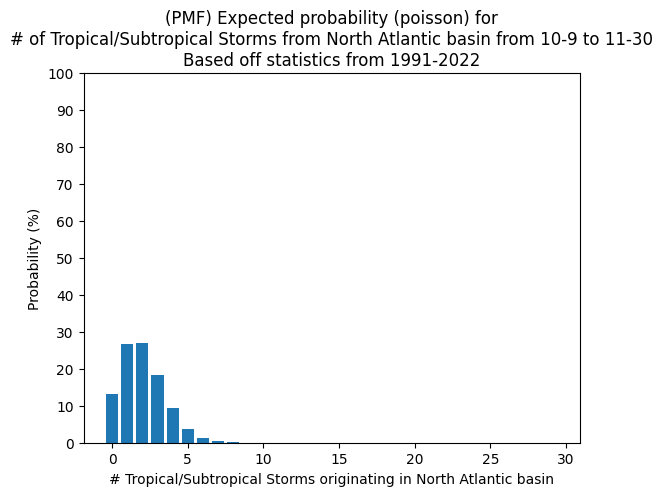

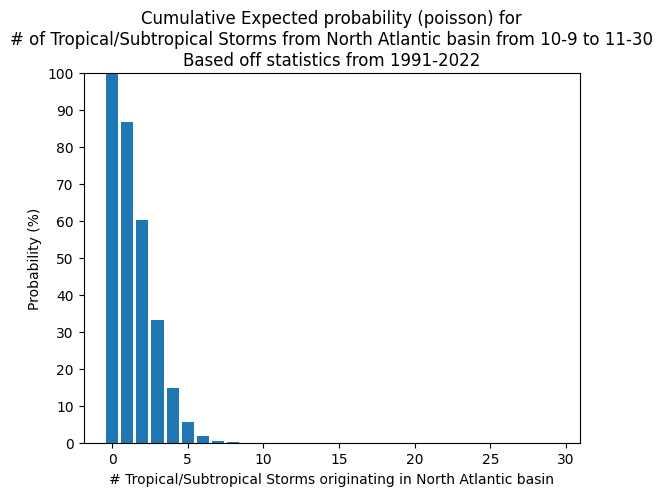

# US Hurricane in records from North Atlantic basin: 594
# US Hurricane from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 31
PMF % (starting from 0): [37.95571881830895, 36.7696026052368, 17.810276261911575, 5.751235042908946, 1.3928772369545106, 0.26986996465993635, 0.0435727547107189, 0.006030158018001276, 0.000730214447492342, 7.859947177868958e-05, 7.614323828560553e-06, 6.705796553561852e-07, 5.413533676052536e-08, 4.0341236528276115e-09, 2.7914694919119637e-10, 1.8028240468598095e-11, 1.0915536221221504e-12, 6.220250420181372e-14, 3.347704219194835e-15, 1.7068886643921036e-16, 8.267741968149252e-18, 3.8139881103069466e-19, 1.6794549917544795e-20, 7.0737914054876145e-22, 2.8553064266942204e-23, 1.1064312403440103e-24, 4.122520246474076e-26, 1.4791449958413934e-27, 5.11757755257625e-29, 1.7095356048476696e-30]
Cumulative % (starting from 0): [100.0, 62.04428118169104, 25.27467857645424, 7.464402314542662, 1.7131672716337143, 0.32029003467920353, 0.050420070019267134, 0.00

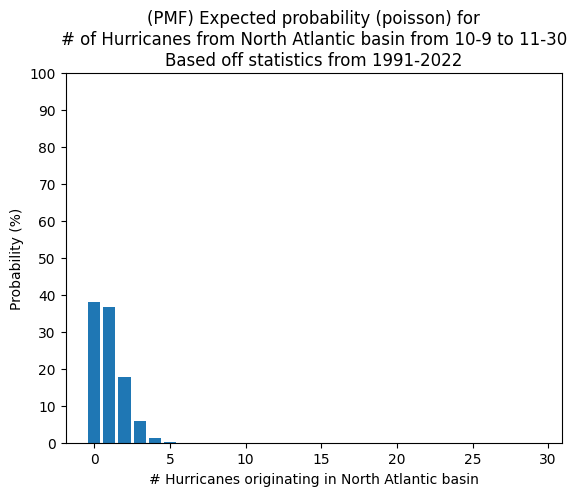

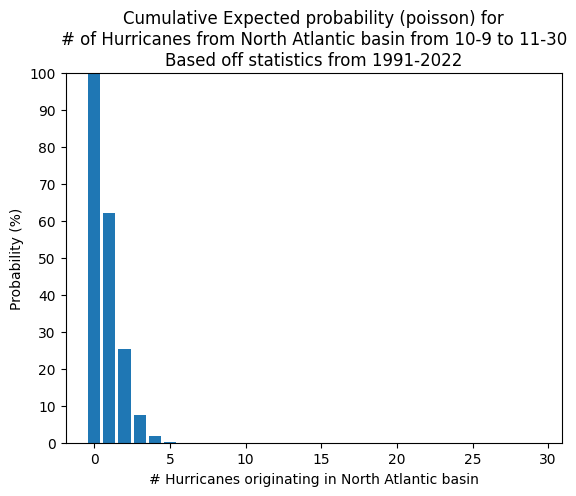

# US Named Storm in records from North Atlantic basin: 1134
# US Named Storm from North Atlantic basin, 1991 to 2022 from 10-9 to 11-30: 65
PMF % (starting from 0): [13.117145431019425, 26.64420165675821, 27.060517307645053, 18.322225260384673, 9.304255015039091, 3.779853599859631, 1.2796379374524793, 0.37132350863576413, 0.09428135961454948, 0.021278779079672627, 0.004322252000558502, 0.0007981431251031324, 0.00013510235190547813, 2.1109742485230963e-05, 3.0627974587946707e-06, 4.1475382254511157e-07, 5.265429387779737e-08, 6.291413790545641e-09, 7.099685701136575e-10, 7.590124516017721e-11, 7.708720211580499e-12, 7.456351395129945e-13, 6.884415350617138e-14, 6.0799863830178516e-15, 5.145821808543756e-16, 4.180980219441801e-17, 3.266390796438907e-18, 2.457354187135752e-19, 1.782678818792677e-20, 1.248643569197457e-21]
Cumulative % (starting from 0): [100.00000000000001, 86.88285456898058, 60.23865291222237, 33.17813560457733, 14.855910344192658, 5.551655329153569, 1.7718017292939388, 

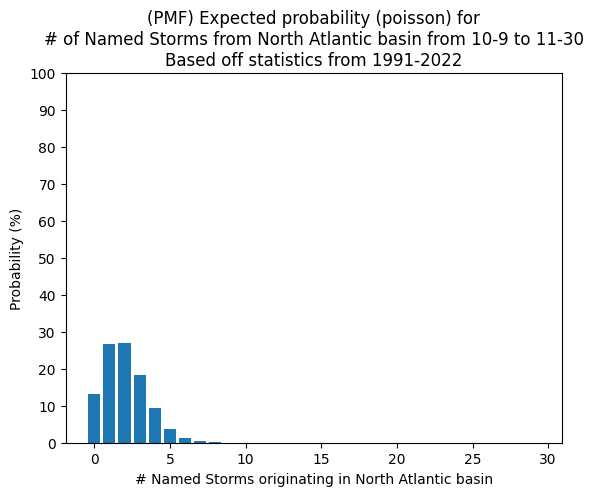

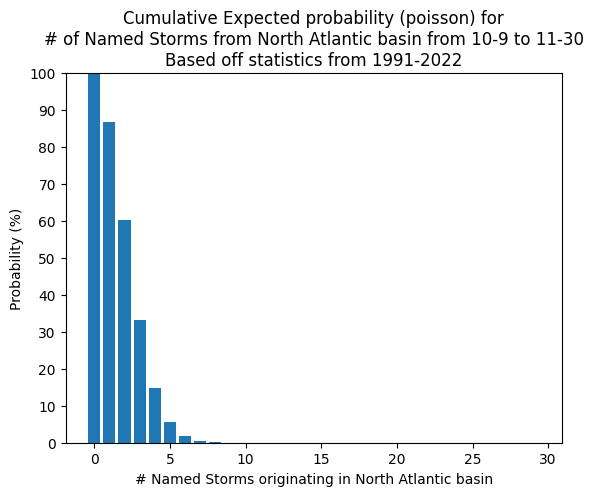

# US Tropical/Subtropical Storm in records from East Pacific basin: 1093
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 65
PMF % (starting from 0): [13.117145431019425, 26.64420165675821, 27.060517307645053, 18.322225260384673, 9.304255015039091, 3.779853599859631, 1.2796379374524793, 0.37132350863576413, 0.09428135961454948, 0.021278779079672627, 0.004322252000558502, 0.0007981431251031324, 0.00013510235190547813, 2.1109742485230963e-05, 3.0627974587946707e-06, 4.1475382254511157e-07, 5.265429387779737e-08, 6.291413790545641e-09, 7.099685701136575e-10, 7.590124516017721e-11, 7.708720211580499e-12, 7.456351395129945e-13, 6.884415350617138e-14, 6.0799863830178516e-15, 5.145821808543756e-16, 4.180980219441801e-17, 3.266390796438907e-18, 2.457354187135752e-19, 1.782678818792677e-20, 1.248643569197457e-21]
Cumulative % (starting from 0): [100.00000000000001, 86.88285456898058, 60.23865291222237, 33.17813560457733, 14.855910344192658, 5.55165532915

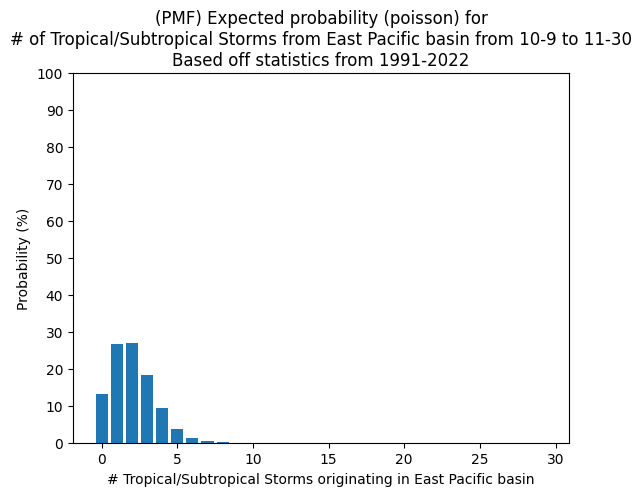

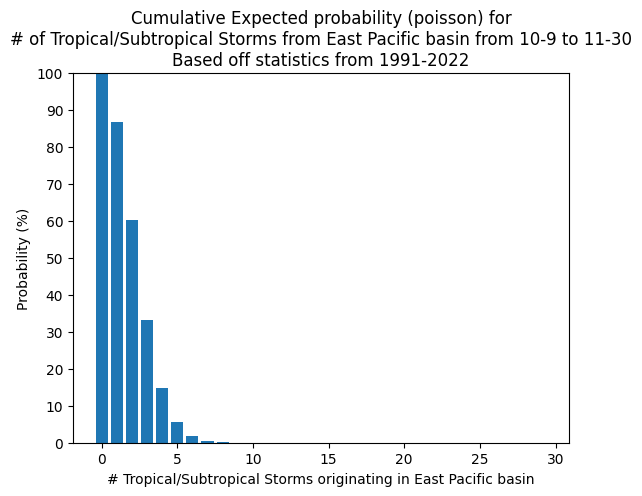

# US Hurricane in records from East Pacific basin: 594
# US Hurricane from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 31
PMF % (starting from 0): [37.95571881830895, 36.7696026052368, 17.810276261911575, 5.751235042908946, 1.3928772369545106, 0.26986996465993635, 0.0435727547107189, 0.006030158018001276, 0.000730214447492342, 7.859947177868958e-05, 7.614323828560553e-06, 6.705796553561852e-07, 5.413533676052536e-08, 4.0341236528276115e-09, 2.7914694919119637e-10, 1.8028240468598095e-11, 1.0915536221221504e-12, 6.220250420181372e-14, 3.347704219194835e-15, 1.7068886643921036e-16, 8.267741968149252e-18, 3.8139881103069466e-19, 1.6794549917544795e-20, 7.0737914054876145e-22, 2.8553064266942204e-23, 1.1064312403440103e-24, 4.122520246474076e-26, 1.4791449958413934e-27, 5.11757755257625e-29, 1.7095356048476696e-30]
Cumulative % (starting from 0): [100.0, 62.04428118169104, 25.27467857645424, 7.464402314542662, 1.7131672716337143, 0.32029003467920353, 0.050420070019267134, 0.006847

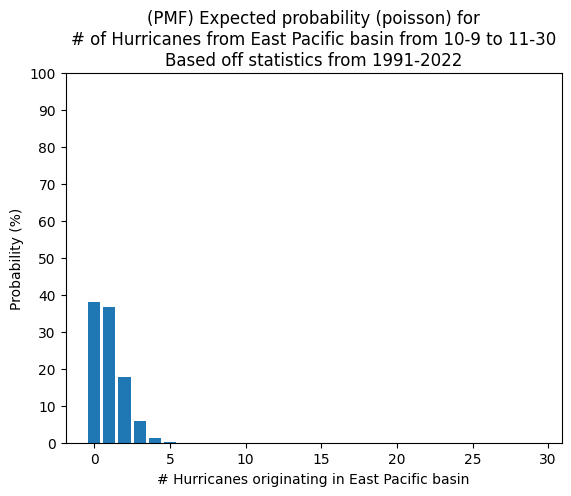

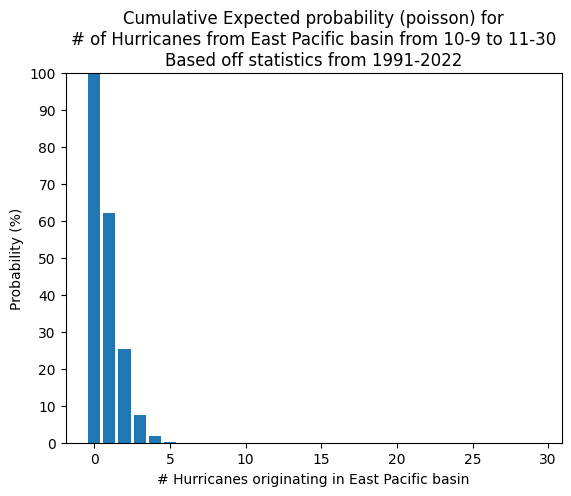

# US Named Storm in records from East Pacific basin: 1134
# US Named Storm from East Pacific basin, 1991 to 2022 from 10-9 to 11-30: 65
PMF % (starting from 0): [13.117145431019425, 26.64420165675821, 27.060517307645053, 18.322225260384673, 9.304255015039091, 3.779853599859631, 1.2796379374524793, 0.37132350863576413, 0.09428135961454948, 0.021278779079672627, 0.004322252000558502, 0.0007981431251031324, 0.00013510235190547813, 2.1109742485230963e-05, 3.0627974587946707e-06, 4.1475382254511157e-07, 5.265429387779737e-08, 6.291413790545641e-09, 7.099685701136575e-10, 7.590124516017721e-11, 7.708720211580499e-12, 7.456351395129945e-13, 6.884415350617138e-14, 6.0799863830178516e-15, 5.145821808543756e-16, 4.180980219441801e-17, 3.266390796438907e-18, 2.457354187135752e-19, 1.782678818792677e-20, 1.248643569197457e-21]
Cumulative % (starting from 0): [100.00000000000001, 86.88285456898058, 60.23865291222237, 33.17813560457733, 14.855910344192658, 5.551655329153569, 1.7718017292939388, 0.49

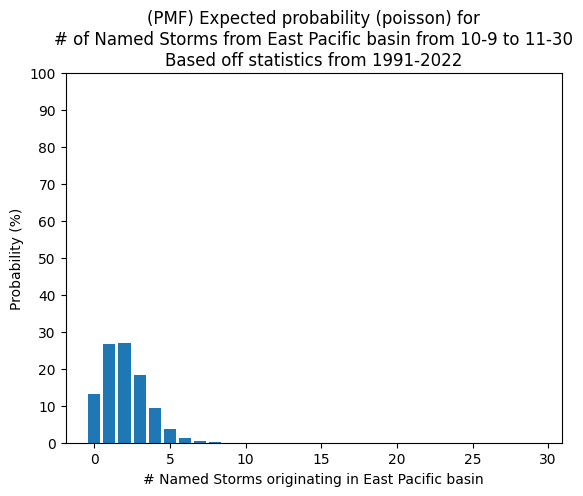

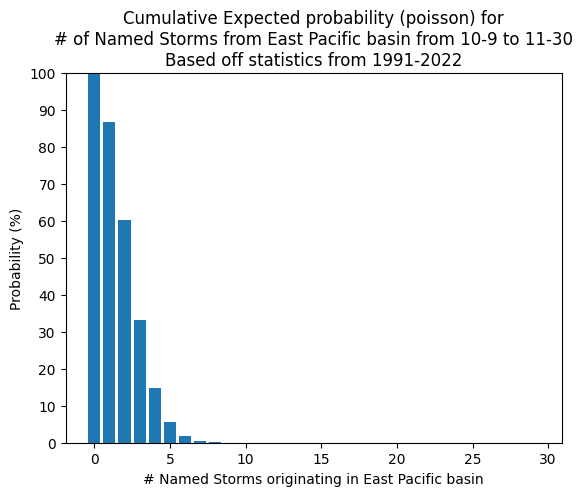

In [219]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2022)
start_year = 1991
end_year = 2022
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 9
end_month = 11
end_day = 30
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]]
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms.reset_index()
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        ep_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            ep_pct_per_event_count.append(pct)
        cum_pct_per_event_count = []
        remaining_pct = pct_total
        # get cumulative probability from pdf
        for pct in ep_pct_per_event_count:
            cum_pct_per_event_count.append(100 * remaining_pct / pct_total)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", ep_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, ep_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()